# Part II

Change the data set (use your choice of a hand written that can be any language symbols data set from any open source) and complete exercise 1 and 2 after the Chapter 3. Submit a short write-up based on your code outputs for each exercise.

- Dataset description: https://ai.stanford.edu/~btaskar/ocr/

## Load data

The tab delimited data file (letter.data.gz) contains a line for each letter and the additional fields:

- id: each letter is assigned a unique integer id
- letter: a-z
- next_id: id for next letter in the word, -1 if last letter
- word_id: each word is assigned a unique integer id (not used)
- position: position of letter in the word (not used)
- fold: 0-9 -- cross-validation fold
- p_i_j: 0/1 -- value of pixel in row i, column j

The matrices are extracted by unzipping the data file, and parsing the tab delimited file to construct numpy arrays

In [ ]:
import gzip
import numpy as np

def load_letter_data(file_path):
    with gzip.open(file_path, 'rt') as file:  # 'rt' mode for text reading
        # Initialize lists to hold data and labels
        data, labels = [], []
        for line in file:
            # Split line into components: ID, letter, next ID, word ID, position, fold, 16x8 attributes, bitmap
            parts = line.strip().split('\t')
            # The letter is in the second column, bitmap starts from column 6 onwards
            label = parts[1]
            bitmap = np.array([int(val) for val in parts[6:134]]).reshape((16, 8))  # Adjust shape according to data structure
            data.append(bitmap)
            labels.append(label)
        data = np.array(data)
        labels = np.array(labels)
    return data, labels

# Example usage
file_path = '/content/letter.data.gz'
data, labels = load_letter_data(file_path)
data.shape

(52152, 16, 8)

Note that the data object constructed is an array that shows the number of rows, and the dimensions of the images. To construct the images this array needs to be flattened before splitting.

In [ ]:
# reshape data to be (52152, 16x8) instead of (52152, 16, 8)
data_flattened = data.reshape(data.shape[0], -1)
data_flattened, data_flattened.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 1, ..., 1, 1, 0]]),
 (52152, 128))

In [ ]:
labels, labels.shape

(array(['o', 'm', 'm', ..., 'i', 'a', 'l'], dtype='<U1'), (52152,))

Now we split the data with a train/test split of 70/30

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_flattened, labels,
                                                    random_state=42, test_size=0.3)

To set a baseline, following the book's advice, I train a vainilla and a hyperparameter tuned k-neighbors classifier.

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)

##
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)


Note that the accuracy barely improved with grid search cross validation.

In [ ]:
print(f"Baseline Accuracy: {baseline_accuracy} \n\n" \
      + f"Tuned Accuracy: {tuned_accuracy}")


Baseline Accuracy: 0.8189313562571904 

Tuned Accuracy: 0.826025821296178


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Custom transformer to flatten the image
class ImageFlattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)

# Create the pipeline
pipeline = Pipeline([
    ('flatten', ImageFlattener()),
    ('scale', StandardScaler()),
])

pipeline.fit_transform(data)

array([[-0.1953475 , -0.25711988, -0.35095116, ..., -0.37231086,
        -0.28204679, -0.2015583 ],
       [-0.1953475 , -0.25711988, -0.35095116, ..., -0.37231086,
        -0.28204679, -0.2015583 ],
       [-0.1953475 , -0.25711988, -0.35095116, ..., -0.37231086,
        -0.28204679, -0.2015583 ],
       ...,
       [-0.1953475 , -0.25711988,  2.84939937, ...,  2.68592758,
        -0.28204679, -0.2015583 ],
       [-0.1953475 , -0.25711988, -0.35095116, ..., -0.37231086,
        -0.28204679, -0.2015583 ],
       [-0.1953475 ,  3.88923637,  2.84939937, ...,  2.68592758,
         3.54551095, -0.2015583 ]])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Assume y is your target data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Transform the training data and test data
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Fit the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_transformed, y_train)

# Compute the score
score = knn.score(X_test_transformed, y_test)
print(f'The accuracy score is {score}')


The accuracy score is 0.8139460565000639


In [ ]:
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train_transformed, y_train)
grid_search.best_estimator_.fit(X_train_transformed, y_train)
tuned_accuracy = grid_search.score(X_test_transformed, y_test)
tuned_accuracy

0.8208487792407005

#### Binary Classifier

The performance of the multiclass classifier was not satisfactory. The next few cells of code implement a binary classifer for the letter 'a'. The accuracy scores recorded are significantly better.

In [ ]:
from sklearn.linear_model import SGDClassifier

y_traina = y_train == "a"
y_testa = y_test == "a"

binary_sgd = SGDClassifier(random_state=42)
binary_sgd.fit(X_train_transformed, y_traina)

SGDClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(binary_sgd, X_train_transformed, y_traina, cv=5, scoring="accuracy")

array([0.94700082, 0.94918504, 0.94959595, 0.94713053, 0.95110259])

In [ ]:
# dummy classifier for benchmark
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_traina)

# we get accuracy scores around 92% because around 8% of the training data are "a"
cross_val_score(dummy_clf, X_train_transformed, y_traina, cv=5, scoring="accuracy"), 100*sum(y_traina)/len(y_train)

(array([0.92289784, 0.92288728, 0.92288728, 0.92288728, 0.92288728]),
 7.711061195419931)

In [ ]:
from collections import Counter

frequency_table = Counter(labels)

total_labels = sum(frequency_table.values())

# Calculating percentages of total labels for each label
percentage_table = {label: (count / total_labels * 100) for label, count in frequency_table.items()}
percentage_table

{'o': 7.4723884031293135,
 'm': 3.071790151863783,
 'a': 7.73508206780181,
 'n': 9.633379352661452,
 'd': 2.764994631078386,
 'i': 9.420539960116582,
 'g': 4.739990796134377,
 'b': 2.462034054302807,
 'r': 5.125402669121031,
 'c': 4.053535818377052,
 'e': 9.501073784322749,
 's': 2.6729559748427674,
 'l': 6.020862095413407,
 'f': 1.765991716520939,
 't': 4.095720202485044,
 'y': 2.3412333179935576,
 'v': 1.2732014112593957,
 'u': 4.912563276576162,
 'z': 2.097714373370149,
 'p': 2.640358950759319,
 'h': 1.650943396226415,
 'j': 0.36240220892774966,
 'q': 0.6538579536738763,
 'x': 0.7919159380273048,
 'w': 0.9970854425525387,
 'k': 1.7429820524620339}

In [ ]:
X_train.shape

(36506, 16, 8)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5,
                                 weights="uniform", algorithm="auto")
knn_model.fit(X_train_transformed, y_traina)

# Already well over 97%
print(f"Base Accuracy = {knn_model.score(X_test_transformed, y_testa)}")

Base Accuracy = 0.9789722612808386


In [ ]:
# with hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = [{"weights": ["uniform", "distance"],
              'n_neighbors': [3,4,5,6],
              "algorithm": ['ball_tree', "kd_tree"]}]

knn_model_tuned = KNeighborsClassifier()
grid_search = GridSearchCV(knn_model_tuned, param_grid, cv=5)
grid_search.fit(X_train_transformed[:len(y_traina)//5], y_traina[:len(y_traina)//5]) # fit on a fifth of the training data to speed up
grid_search.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}

In [ ]:
grid_search.best_estimator_.fit(X_train_transformed, y_traina)
tuned_accuracy = grid_search.score(X_test_transformed, y_testa)
tuned_accuracy # A little better than base

0.9783970343857855

#### Data Augmentation

In [ ]:
from scipy.ndimage import shift
import matplotlib.pyplot as plt

def shift_image(img, change_x, change_y):
    image = img.reshape((16, 8))
    shifted_image = shift(image, [change_x, change_y], cval=0, mode="constant")
    return shifted_image.reshape([-1])

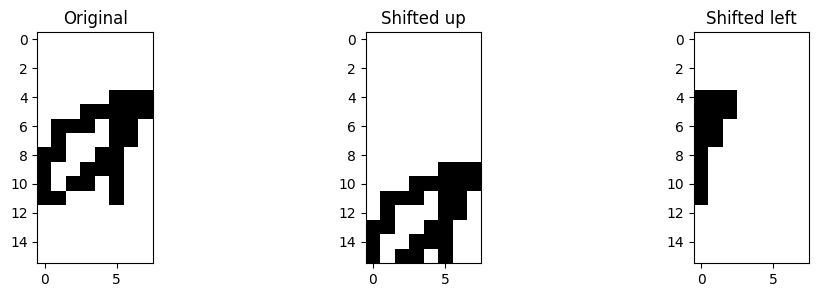

In [ ]:
image = X_train[1000]  # some random digit to demo
shifted_image_up = shift_image(image, 5, 0)
shifted_image_left = shift_image(image, 0, -5)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(16, 8),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted up")
plt.imshow(shifted_image_up.reshape(16, 8),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(16, 8),
           interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

X_train_augmented.shape, y_train_augmented.shape

((182530, 128), (182530,))

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

augmented_accuracy = knn_clf.score(X_test, y_test)

In [ ]:
baseline_accuracy, augmented_accuracy

(0.8189313562571904, 0.8413012910648089)